# Week 5 Final Report: The Battle of Neighborhoods

Opening a New Restaurant in Delhi, India

1.	Create a dataframe of neighborhoods in Delhi, India from the data (CSV file) complied from Wikipedia and Google.
2.	Obtain the venue data for the neighborhoods from Foursquare API.
3.	Explore and cluster the neighborhoods.
4.	Select the best cluster to open the Street Food Restaurant.

### PART 1: DATAFRAME WITH NEIGHBORHOODS AND GEOGRAPHICAL COORDINATES

###### Import required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported


###### Load the data from the CSV file

In [2]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Latitude,Longitude
0,Adarsh Nagar,28.7193,77.1736
1,Ashok Vihar,28.6910,77.1765
2,Begum Pur,28.7239,77.0609
3,Karala,28.7406,77.0363
4,Model Town,28.7095,77.1888


###### Results:

1. As per data, there are 116 neighborhoods in Delhi.
2. Delhi’s urban area including neighboring satellite cities is the world’s second largest urban area according to the United Nations (Wikipedia).

### PART 2: EXPLORE THE NEIGHBORHOODS IN DELHI, INDIA

###### Get the Geographical Coordinates of Delhi

In [3]:
address = 'Delhi'

geolocator = Nominatim(user_agent="delhi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Delhi are 28.6517178, 77.2219388.


###### Create a map of Delhi with neighborhoods superimposed on top

In [4]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(delhi_data['Latitude'], delhi_data['Longitude'], delhi_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_delhi)  
    
map_delhi

###### Save the Map as a HTML file

In [5]:
# save the map as HTML file
map_delhi.save('map_delhi.html')

###### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'JVG2BBF3MVJZGZTYKONHVB5JHXVVBH0STYKDI434I13U4QHR' # your Foursquare ID
CLIENT_SECRET = 'SOHXX2CBQB2WZQQUIMIA44EUIZKHQQY1KRJKEYLN32JYROCI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: JVG2BBF3MVJZGZTYKONHVB5JHXVVBH0STYKDI434I13U4QHR
CLIENT_SECRET:SOHXX2CBQB2WZQQUIMIA44EUIZKHQQY1KRJKEYLN32JYROCI


###### Now, let’s get the top 100 venues that are within a radius of 1000 meters

In [7]:
radius = 1000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(delhi_data['Latitude'], delhi_data['Longitude'], delhi_data['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

###### Create the venues list in the form of a Dataframe

In [8]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(2106, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adarsh Nagar,28.7193,77.1736,Adarsh Nagar Metro Station,28.716598,77.170436,Light Rail Station
1,Adarsh Nagar,28.7193,77.1736,Vishyavidyalaya Metro Station@Entry gate #1 n ...,28.715596,77.170981,Train Station
2,Adarsh Nagar,28.7193,77.1736,Axis Bank ATM,28.722080,77.168740,ATM
3,Adarsh Nagar,28.7193,77.1736,Bandhu Dental Clinic,28.714134,77.167224,Spa
4,Adarsh Nagar,28.7193,77.1736,Woodland Original,28.716670,77.183330,Clothing Store


###### Check how many venues were returned for each neighborhood

In [9]:
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Adarsh Nagar,5,5,5,5,5,5
Alaknanda,33,33,33,33,33,33
Anand Vihar,13,13,13,13,13,13
Ashok Nagar,27,27,27,27,27,27
Ashok Vihar,12,12,12,12,12,12
Badarpur,4,4,4,4,4,4
Bali Nagar,17,17,17,17,17,17
Barakhamba Road,94,94,94,94,94,94
Begum Pur,5,5,5,5,5,5


###### Find out how many unique categories can be curated from all the returned venues

In [10]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

# print out the list of categories
venues_df['VenueCategory'].unique()[:50]

There are 195 uniques categories.


array(['Light Rail Station', 'Train Station', 'ATM', 'Spa',
       'Clothing Store', 'Asian Restaurant', 'Sandwich Place',
       'Pizza Place', 'Snack Place', 'South Indian Restaurant',
       'Indian Restaurant', 'Coffee Shop', 'Market', 'Dessert Shop',
       'Accessories Store', 'Restaurant', 'Bakery', 'Food Truck',
       'Donut Shop', 'Chinese Restaurant', 'Fast Food Restaurant',
       'Frozen Yogurt Shop', 'Park', 'Shopping Mall', 'Bus Station',
       'Convenience Store', 'Hotel', 'Metro Station', 'Diner',
       'Business Service', 'IT Services', 'Mobile Phone Shop', 'Airport',
       'Shoe Store', 'Burger Joint', 'Smoke Shop', 'Trail',
       'Breakfast Spot', 'Miscellaneous Shop', 'Playground',
       'Dumpling Restaurant', 'Grocery Store', 'Café', 'Flea Market',
       'Fried Chicken Joint', 'Boutique', 'Historic Site', 'Lake',
       'American Restaurant', 'Food & Drink Shop'], dtype=object)

###### Check whether there are Fast Food Restaurants in Delhi

In [11]:
# check if the results contain "Fast Food Restaurant"
"Fast Food Restaurant" in venues_df['VenueCategory'].unique()

True

###### Analyze Each Neighborhood

In [12]:
# one hot encoding
delhi_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(delhi_onehot.columns[-1:]) + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

print(delhi_onehot.shape)
delhi_onehot.head()

(2106, 196)


,Neighborhoods,ATM,Accessories Store,Airport,Airport Food Court,Airport Lounge,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Bus Station,Business Service,Café,Campground,Check Cashing Service,Chinese Restaurant,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hindu Temple,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Karnataka Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Office,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

###### Next, let’s group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [13]:
delhi_grouped = delhi_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(delhi_grouped.shape)
delhi_grouped

(114, 196)


,Neighborhoods,ATM,Accessories Store,Airport,Airport Food Court,Airport Lounge,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Bus Station,Business Service,Café,Campground,Check Cashing Service,Chinese Restaurant,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hindu Temple,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Karnataka Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Office,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adarsh Nagar,0.200000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

###### Now, let’s create the new dataframe and display the top 10 venues for each Neighborhood

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = delhi_grouped['Neighborhoods']

for ind in np.arange(delhi_grouped.shape[0]):
    row_categories = delhi_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(114, 11)


,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,ATM,Light Rail Station,Clothing Store,Train Station,Spa,Falafel Restaurant,Farmers Market,Gourmet Shop,Golf Course,Gift Shop
1,Alaknanda,Coffee Shop,Restaurant,Pizza Place,BBQ Joint,Indian Restaurant,Market,Convenience Store,Italian Restaurant,Gym,New American Restaurant
2,Anand Vihar,Pizza Place,Shopping Mall,Indian Restaurant,Train Station,Gym,Multiplex,Café,Food Truck,South Indian Restaurant,Yoga Studio
3,Ashok Nagar,Fast Food Restaurant,Clothing Store,Donut Shop,Restaurant,Shopping Mall,Coffee Shop,Multiplex,Bakery,Sculpture Garden,Café
4,Ashok Vihar,Indian Restaurant,Snack Place,Sandwich Place,Dessert Shop,Market,Asian Restaurant,Coffee Shop,South Indian Restaurant,Pizza Place,French Restaurant
5,Badarpur,Light Rail Station,Indian Restaurant,Train Station,Zoo,Food Truck,Golf Course,Gift Shop,Gastropub,Garden Center,Garden
6,Bali Nagar,Pizza Place,Chinese Restaurant,Light Rail Station,Fast Food Restaurant,Restaurant,Shopping Mall,American Restaurant,Shoe Store,Ice Cream Shop,Metro Station
7,Barakhamba Road,Indian Restaurant,Café,Bar,Chinese Restaurant,Clothing Store,Coffee Shop,Hotel,Lounge,Bakery,Italian Restaurant
8,Begum Pur,Accessories Store,Indian Restaurant,Restaurant,Bakery,Food Truck,Zoo,French Restaurant,Golf Course,Gift Shop,Gastropub
9,Chanakyapuri,Indian Restaurant,Nightclub,Café,Chinese Restaurant,Karnataka Restaurant,BBQ Joint,Smoke Shop,Moroccan Restaurant,Restaurant,Mediterranean Restaurant


###### Get the total number of Fast Food Restaurant that are in Delhi

In [16]:
len(delhi_grouped[delhi_grouped["Fast Food Restaurant"] > 0])

45

###### Create a new DataFrame for Fast Food Restaurant data only

In [17]:
delhi_FF_restaurant = delhi_grouped[["Neighborhoods", "Fast Food Restaurant"]]
delhi_FF_restaurant.head()

,Neighborhoods,Fast Food Restaurant
0,Adarsh Nagar,0.000000
1,Alaknanda,0.000000
2,Anand Vihar,0.000000
3,Ashok Nagar,0.148148
4,Ashok Vihar,0.000000


###### Results:

1. Since the theme of the restaurant that the client intends to open is “Street Food”, we consider Fast Food Restaurants as the main competition.
2. There are 45 Fast Food Restaurants in Delhi. Considering the size of Delhi, the number is very low.
3. When we look at the top ten venues for each neighborhood, we find that restaurants and various other food outlets are most common in the list. This indicates that Delhi people prefer eating out.

### PART 3: CLUSTER THE NEIGHBORHOODS OF DELHI, INDIA

###### Cluster Areas

###### Run k-means to cluster Delhi area into 5 clusters

In [18]:
# set number of clusters
kclusters = 5

delhi_clustering = delhi_FF_restaurant.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# create a new dataframe that includes the cluster as well as Fast food chains in each neighborhood.
delhi_merged = delhi_FF_restaurant.copy()

# add clustering labels
delhi_merged["Cluster Labels"] = kmeans.labels_

delhi_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
delhi_merged.head()

# merge delhi_grouped with delhi_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(delhi_data.set_index("Neighborhood"), on="Neighborhood")

print(delhi_merged.shape)
delhi_merged.head() 

# sort the results by Cluster Labels
print(delhi_merged.shape)
delhi_merged.sort_values(["Cluster Labels"], inplace=True)
delhi_merged

(114, 5)
(114, 5)


,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
0,Adarsh Nagar,0.000000,0,28.7193,77.1736
76,Pragati Maidan,0.000000,0,28.6189,77.2441
75,Pitam Pura,0.000000,0,28.6990,77.1387
74,Patel Nagar,0.000000,0,28.6554,77.1646
72,Pandav Nagar,0.000000,0,28.6148,77.2777
71,Palam,0.000000,0,28.5901,77.0888
69,Okhla,0.000000,0,28.5626,77.2914
67,New Usmanpur,0.000000,0,28.6818,77.2579
65,Netaji Nagar,0.000000,0,26.3199,89.6655
78,Punjabi Bagh,0.000000,0,28.6620,77.1242


###### Finally, let’s visualize the resulting clusters

In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###### Save the Map as a HTML file

In [20]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

###### Examine Clusters

###### Cluster 1

In [21]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
0,Adarsh Nagar,0.000000,0,28.7193,77.1736
76,Pragati Maidan,0.000000,0,28.6189,77.2441
75,Pitam Pura,0.000000,0,28.6990,77.1387
74,Patel Nagar,0.000000,0,28.6554,77.1646
72,Pandav Nagar,0.000000,0,28.6148,77.2777
71,Palam,0.000000,0,28.5901,77.0888
69,Okhla,0.000000,0,28.5626,77.2914
67,New Usmanpur,0.000000,0,28.6818,77.2579
65,Netaji Nagar,0.000000,0,26.3199,89.6655
78,Punjabi Bagh,0.000000,0,28.6620,77.1242


###### Cluster 2

In [22]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
54,Model Town,0.083333,1,28.7095,77.1888
45,Kotwali,0.103448,1,28.6586,77.2312
46,Lajpat Nagar,0.083333,1,28.5649,77.2403
109,Vikaspuri,0.111111,1,28.6386,77.0721
39,Kamla Nagar,0.107143,1,28.6809,77.2046
101,Tihar Village,0.103448,1,28.6370,77.1072
10,Chandni Chowk,0.076923,1,28.6505,77.2303
94,Shakti Nagar,0.090909,1,28.6800,77.1976
58,Munirka,0.100000,1,28.5532,77.1745
22,East of Kailash,0.081081,1,28.5583,77.2531


###### Cluster 3

In [23]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 2]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
89,Sarai Rohilla,0.200000,2,28.6676,77.1858
41,Kashmere Gate,0.230769,2,28.6665,77.2333
25,Govindpuri,0.250000,2,28.5354,77.2639


###### Cluster 4

In [24]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 3]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
84,Safdarjung Enclave,0.062500,3,28.5647,77.1949
70,Paharganj,0.038462,3,28.6456,77.2128
63,Neeti Bagh,0.043478,3,28.5595,77.2168
107,Vasant Vihar,0.064516,3,28.5603,77.1617
6,Bali Nagar,0.058824,3,28.6550,77.1321
99,Sri niwaspuri,0.062500,3,28.5661,77.2530
68,Nizamuddin West,0.057143,3,28.5892,77.2427
11,Chittaranjan Park,0.062500,3,28.5398,77.2490
43,Kirti Nagar,0.071429,3,28.6494,77.1437
66,New Friends Colony,0.040000,3,28.5675,77.2691


###### Cluster 5

In [25]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 4]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
33,Inderpuri,0.142857,4,28.6320,77.1451
38,Kalkaji,0.133333,4,28.5400,77.2592
79,Rajinder Nagar,0.142857,4,28.6372,77.1824
80,Rajouri Garden,0.129032,4,28.6417,77.1225
40,Karol Bagh,0.166667,4,28.6550,77.1888
91,Sarojini Nagar,0.166667,4,28.5740,77.1991
106,Vasant Kunj,0.125000,4,28.5293,77.1484
3,Ashok Nagar,0.148148,4,28.6374,77.1014
55,Mori Gate,0.137931,4,28.6630,77.2276
34,Jangpura,0.133333,4,28.5826,77.2487


###### Results:

1. Using Machine Learning technique (K-Means Clustering), we have divided Delhi’s neighborhoods into five clusters.
2. Apart from cluster 0, all other clusters have Fast Food Restaurants in all the neighborhoods. Only five neighborhoods in Cluster 0 have Fast Food Restaurants. 
3. Also, Cluster 0 has the highest number of neighborhoods (74) accounting for 64% of the total neighborhoods in Delhi . The second and third clusters in terms of neighborhoods is Cluster 1 (14) and cluster 4 (12).

### PART 4: DISTRICTS IN DELHI, INDIA

###### Load the data from the CSV file to get information on which part of Delhi the neighborhoods are

In [26]:
body = client_4c0fcb1fb13c445d8b1a05284d607f80.get_object(Bucket='course9datasciencecapstoneibm-donotdelete-pr-as9y8gremq47yc',Key='Delhi_Districts.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

delhi_districts = pd.read_csv(body)
delhi_districts

,District,Neighborhood
0,North West Delhi,Adarsh Nagar
1,North West Delhi,Ashok Vihar
2,North West Delhi,Begum Pur
3,North West Delhi,Karala
4,North West Delhi,Model Town
5,North West Delhi,Narela
6,North West Delhi,Pitam Pura
7,North West Delhi,Rohini
8,North West Delhi,Shalimar Bagh
9,North Delhi,Civil Lines


###### Results:

1. Delhi is divided into nine districts – North West Delhi, North Delhi, North East Delhi, Central Delhi, New Delhi, East Delhi, South Delhi, South West Delhi, and West Delhi.
2. As per data, South Delhi contains the maximum number of neighborhoods (37) followed by South West Delhi (15) and West Delhi (13).

### PART 5: POPULATION – DISTRICT WISE IN DELHI, INDIA

###### Import the required libraries

In [27]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

###### Load the data regarding population (District wise) in Delhi from the CSV file

In [28]:
body = client_4c0fcb1fb13c445d8b1a05284d607f80.get_object(Bucket='course9datasciencecapstoneibm-donotdelete-pr-as9y8gremq47yc',Key='Delhi_Population.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

delhi_population = pd.read_csv(body)
delhi_population

,District,Population
0,North West Delhi,3656539
1,North Delhi,887978
2,North East Delhi,2241624
3,Central Delhi,582320
4,New Delhi,142004
5,East Delhi,1709346
6,South Delhi,2731929
7,South West Delhi,2292958
8,West Delhi,2543243


###### Set District as the index for the table

In [29]:
delhi_population.set_index('District', inplace=True)
delhi_population

,Population
District,
North West Delhi,3656539
North Delhi,887978
North East Delhi,2241624
Central Delhi,582320
New Delhi,142004
East Delhi,1709346
South Delhi,2731929
South West Delhi,2292958
West Delhi,2543243


###### Plot the bar chart of population for better visualization

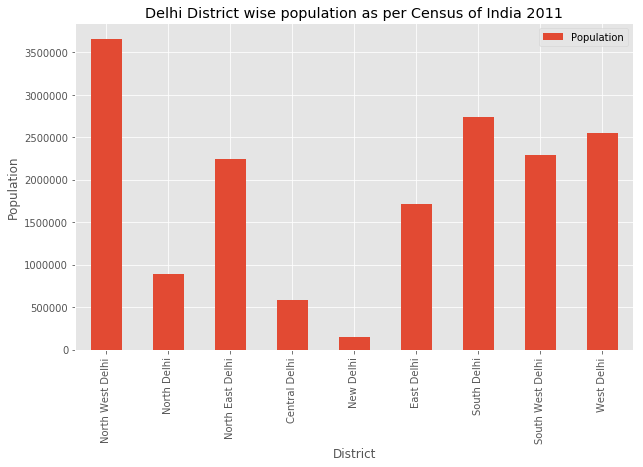

In [30]:
delhi_population.plot(kind='bar', figsize=(10, 6))

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Delhi District wise population as per Census of India 2011') # add title to the plot

plt.show()

###### Results:

1. As per data, North West Delhi is the most populated district in Delhi (3656539) followed by South Delhi (2731929) and West Delhi (2543243).
2. Delhi is second most populated city in India and fifth most populous city in the world (Wikipedia).
3. Delhi ranks fifth in the world in terms of population density (9340 persons/ Sq. km)  (Wikipedia).

###### Discussion:

1. Location is of prime importance when deciding to open a restaurant. The location selected should ensure that the restaurant faces less competition. Since the restaurant will serve street food, we decided to get information of Fast Food Restaurants in Delhi which we consider as the main competitors.
2. Cluster 0 with 74 neighborhoods has only five neighborhoods with Fast Food Restaurants compared to other clusters where all neighborhoods have Fast Food Restaurants. Hence, we have selected the cluster to open the restaurant. 
3. We have further trimmed the number of neighborhoods in Cluster 0 based on districts with high population. The trimmed list contains 33 neighborhoods – North West Delhi (7), South Delhi (23) and West Delhi (3).

###### Recommendations:

1. We  recommend the client to open his “Street Food Restaurant” in the neighborhoods of South Delhi (23) from cluster 0. The reason being South Delhi is second most populated and expensive area in Delhi. 
2. We suggested to the client to consider “International Street Food” as the theme of the restaurant. Since South Delhi is an expensive area, the local population will be interested in international food options. They will readily connect with the theme of the restaurant. 
2. The theme of “International Street Food” will also act as a differentiation factor preventing competition from local street vendors and Fast Food Chains selling pizzas and burgers.
3. We also recommend the client to consider food quality, restaurant layout and customer service equally important in order to ensure that customers come to the restaurant on a regular basis as well as recommend it to other people.

###### Conclusion:

We suggest that the client should open the restaurant in one of the 23 neighborhoods of South Delhi from Cluster 0 with the theme of “International Street Food” and give equal importance to food quality, restaurant layout and customer service.